In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

['normalRequestTest.txt', 'normalTrafficTraining.txt', 'anomalousRequestTest.txt', 'anomalousTrafficTest.txt', 'normalRequestTraining.txt', 'normalTrafficTest.txt']


In [3]:
import urllib.parse
from sklearn import tree
import io
import string
import numpy as np

In [4]:
# Algorithm based preprocessing FINAL
def parse_file(file_in, file_out):
    fin = open(file_in)
    fout = io.open(file_out, "w", encoding="utf-8")
    lines = fin.readlines()
    
    for i in range(len(lines)):
        line = lines[i].strip()
        res = ""
        if line.startswith("GET"):
            # Decode the URL from the GET requests
            res+="GET" + line.split(" ")[1]
            val = decode_url(res)
            fout.writelines(val + '\n')
        elif line.startswith("POST") or line.startswith("PUT"):
            # Decode the URL from the POST and PUT requests
            url = line.split(' ')[0] + line.split(' ')[1]
            val = decode_url(url)
            fout.writelines(val + '\n')
        elif lines[i-2].startswith("Content-Length"):
            # Decode the url at the bottom of the POST request
            val = decode_url(line)
            fout.writelines(val + '\n')
        elif line == "" and (lines[i-1].startswith("Content-Length") or lines[i-1].strip() == ""):
            # To remove the space between the POST/PUT request and the ID at the bottom
            # Also, to remove the double "\n" between GET requests
            continue
        else:
            # Write all other lines without decoding
            fout.writelines(line + '\n')
            
    print ("finished parse")
    fout.close()
    fin.close()
                    
def decode_url(line):
    # Gets rid of escape characters in the URL
    # requests will be in lower case
    line = urllib.parse.unquote(line).replace('\n','').lower()
    return line

In [ ]:
parse_file(normal_file_raw,normal_file_parse)
parse_file(anomaly_file_raw,anomaly_file_parse)
parse_file(normal_test_raw,normal_test_parse)

In [5]:
def loadData(file):
    list_requests = []
    with open(file, 'r', encoding="utf8") as f:
        data = f.readlines()
    result = []
    for d in data:
        d = d.strip()
        if (len(d) > 0):
            result.append(d)
        else:
            list_requests.append("\n".join(result))
            result = []
            continue
    return list_requests

In [6]:
X_train=loadData('../input/normalRequestTraining.txt')
X_test_bad=loadData('../input/anomalousRequestTest.txt')
X_test_good=loadData('../input/normalRequestTest.txt')



In [7]:
y_bad = [1]*len(X_test_bad)

y_good = [0]*len(X_test_good)
y_unshuffled = y_bad+y_good
X_unshuffled = X_test_bad + X_test_good

print(len(y_bad),len(y_good), len(y_unshuffled))


25065 36000 61065


In [9]:
import numpy as np
from sklearn.utils import shuffle
from keras.utils.np_utils import to_categorical


# 0 --> good --> [1. 0.]
# 1 --> bad -->  [0. 1.]

X_shuffled, y_shuffled = shuffle(X_unshuffled, y_unshuffled)
y_shuffled = to_categorical(y_shuffled)



In [10]:
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical

def load_data(X,y):
    
    x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=21)
    return (x_train, y_train), (x_test, y_test)

In [11]:
def encode_data(x, maxlen, vocab):
    # Iterate over the loaded data and create a matrix of size (len(x), maxlen)
    # Each character is encoded into a one-hot array later at the lambda layer.
    # Chars not in the vocab are encoded as 0, into an all zero vector.
    #--------account for unicode instaed of replaceing with 0----------------------

    input_data = np.zeros((len(x), maxlen), dtype=np.int)
    for dix, sent in enumerate(x):
        counter = 0
        for c in sent:
            c=c.lower()
            if counter >= maxlen:
                pass
            else:
                ix = vocab.get(c, -1)  # get index from vocab dictionary, if not in vocab, return -1
                input_data[dix, counter] = ix
                counter += 1
    return input_data


def create_vocab_set():
    # This alphabet is 69 chars vs. 70 reported in the paper since they include two
    # '-' characters. See https://github.com/zhangxiangxiao/Crepe#issues.
    # -----------------------See if you can include spanish characters ---------------

    alphabet = set(list(string.ascii_lowercase) + list(string.digits) +
                   list(string.punctuation) + ['\n'])
    vocab_size = len(alphabet)
    vocab = {}
    reverse_vocab = {}
    for ix, t in enumerate(alphabet):
        vocab[t] = ix
        reverse_vocab[ix] = t

    return vocab, reverse_vocab, vocab_size, alphabet

In [12]:
from keras.models import Model
from keras.optimizers import SGD, Adam
from keras.layers import Input, Dense, Dropout, Flatten, Lambda, Embedding
from keras.layers.convolutional import Convolution1D, MaxPooling1D
from keras.initializers import RandomNormal
from keras.layers import BatchNormalization
from keras import metrics

def create_model(filter_kernels, dense_outputs, maxlen, vocab_size, nb_filter, cat_output):
    initializer = RandomNormal(mean=0.0, stddev=0.05, seed=None)

    # Define what the input shape looks like
    inputs = Input(shape=(maxlen,), dtype='int64')

   
    # Use Embedding layer as following
    # Think of it as a one-hot embedding and a linear layer mashed into a single layer.
    # See discussion here: https://github.com/keras-team/keras/issues/4838
    # Note this will introduce one extra layer of weights (of size vocab_size x vocab_size = 69*69 = 4761)
    # 210 -> vocab size (using 4 times the vocab size to minimize collisions, 128 -> size of embedding vectors, maxlen -> 1000, size of each request)
#     embedded = Embedding(300, 128)(inputs)
    embedded = Embedding(output_dim=128, input_dim=75, input_length=1000)(inputs)


    # All the convolutional layers...
    conv = Convolution1D(filters=nb_filter, kernel_size=filter_kernels[0],
                         padding='valid', activation='relu',
                         input_shape=(maxlen,))(embedded)
    conv = MaxPooling1D(pool_size=5)(conv)

    conv1 = Convolution1D(filters=nb_filter, kernel_size=filter_kernels[1],
                          padding='valid', activation='relu')(conv)
    conv1 = MaxPooling1D(pool_size=40)(conv1)

    conv2 = Flatten()(conv1)

    # Two dense layers with dropout of .5
    x = Dense(dense_outputs, activation='relu')(conv2)
#     y = BatchNormalization()(x)
    z = Dropout(0.5)(x)

    # Output dense layer with softmax activation
    pred = Dense(cat_output, activation='softmax', name='output')(z)

    model = Model(inputs=inputs, outputs=pred)

#     sgd = SGD(lr=0.01, momentum=0.9)
    adam = Adam(lr=0.001)  # Feel free to use SGD above. I found Adam with lr=0.001 is faster than SGD with lr=0.01
    model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])

    return model

In [13]:
from __future__ import print_function
from __future__ import division
import json
import numpy as np
np.random.seed(123)  # for reproducibility
from keras.callbacks import ModelCheckpoint, EarlyStopping


# set parameters:

subset = None

# Maximum length. Longer gets chopped. Shorter gets padded.
maxlen = 1000

# Model params
# Filters for conv layers
nb_filter = 64
# Number of units in the dense layer
dense_outputs = 64
# Conv layer kernel size
filter_kernels = [5,5]
# Number of units in the final output layer. Number of classes.
cat_output =2

# Compile/fit params
batch_size = 128
nb_epoch = 20

print('Loading data...')
# # Expect x to be a list of sentences. Y to be index of the categories.
(xt, yt), (x_test, y_test) = load_data(X_shuffled,y_shuffled)

print('Creating vocab...')
vocab, reverse_vocab, vocab_size, alphabet = create_vocab_set()

print('Build model...')
model = create_model(filter_kernels, dense_outputs, maxlen, vocab_size,
                              nb_filter, cat_output)
# Encode data
xt = encode_data(xt, maxlen, vocab)
x_test = encode_data(x_test, maxlen, vocab)

print('Chars vocab: {}'.format(alphabet))
print('Chars vocab size: {}'.format(vocab_size))
print('X_train.shape: {}'.format(xt.shape))
print('X_train[0][0].shape: {}'.format(xt[0][0].shape))
model.summary()
print('Fit model...')
pat = 5 #this is the number of epochs with no improvment after which the training will stop
early_stopping = EarlyStopping(monitor='val_loss', patience=pat, verbose=1)
model_checkpoint = ModelCheckpoint('clcnn.h5', verbose=1, save_best_only=True)
history = model.fit(xt, yt,validation_split=0.1, batch_size=batch_size, epochs=nb_epoch, shuffle=True, callbacks=[early_stopping, model_checkpoint], 
              verbose=1)
# validation_split=0.1,
# score = model.evaluate(x_test, y_test, batch_size=128)


Loading data...
Creating vocab...
Build model...
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Chars vocab: {'5', 'i', '&', '_', '|', '?', '>', '+', 'b', '@', 'r', 'a', '*', 'j', 'x', 'v', 'l', ':', '9', '(', 'n', '$', 'p', 'u', 't', 'f', 'm', '/', '=', ';', '-', '{', '}', '3', 'o', '[', ']', '~', 'e', '%', '`', '8', 's', '.', '\\', '0', '7', "'", ',', '^', 'g', 'd', 'h', '2', 'q', '6', '<', '\n', 'w', '!', '4', '1', 'c', 'y', '"', '#', 'z', ')', 'k'}
Chars vocab size: 69
X_train.shape: (54958, 1000)
X_train[0][0].shape: ()
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 1000)              0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 1000, 128)         9600      

In [14]:
from keras.models import Sequential, load_model

model = load_model('clcnn.h5')

score = model.evaluate(x_test, y_test, batch_size=128)

print('Test loss:', score[0])
print('Test accuracy:', score[1])

6107/6107 [==============================] - 0s 60us/step
Test loss: 0.02300719559846581
Test accuracy: 0.9921401670409709


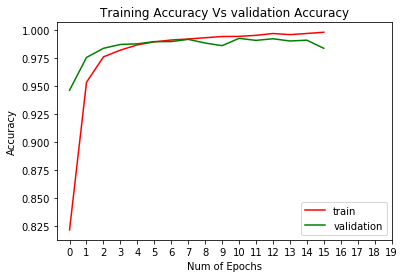

In [15]:
import matplotlib.pyplot as plt 
# Only if val accuracy is used
plt.figure(0)
plt.figsize = (10,10)
plt.plot(history.history['acc'],'r')
plt.plot(history.history['val_acc'],'g')
plt.xticks(np.arange(0, 20, 1.0))
plt.xlabel("Num of Epochs")
plt.ylabel("Accuracy")
plt.title("Training Accuracy Vs validation Accuracy")
plt.legend(['train','validation'])

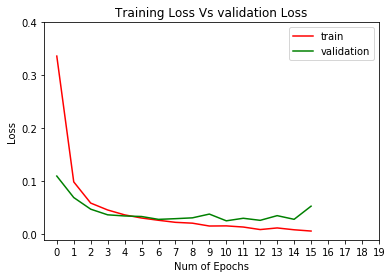

In [16]:
plt.figure(0)
plt.figsize = (10,10)
plt.plot(history.history['loss'],'r')
plt.plot(history.history['val_loss'],'g')
plt.xticks(np.arange(0, 20,1.0))
plt.yticks(np.arange(0, 0.5, 0.1))
plt.xlabel("Num of Epochs")
plt.ylabel("Loss")
plt.title("Training Loss Vs validation Loss")
plt.legend(['train','validation'])

[[3592   12]
 [  36 2467]]


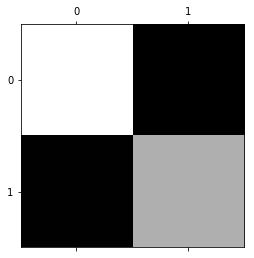

In [17]:
from sklearn.metrics import classification_report, confusion_matrix
y_pred = model.predict(x_test)
y_pred1 = (y_pred > 0.5)
#conf = confusion_matrix( y_test, y_pred)

matrix = confusion_matrix(y_test.argmax(axis=1), y_pred1.argmax(axis=1))

print(matrix)

plt.matshow(matrix, cmap = plt.cm.gray)
plt.show()

[[0.99667037 0.00332963]
 [0.01438274 0.98561726]]


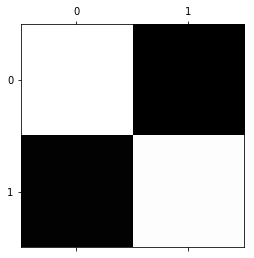

In [18]:
row_sum = matrix.sum(axis=1, keepdims = True)
norm_conf = matrix / row_sum

# np.fill_diagonal(norm_conf, 1)
print(norm_conf)
plt.matshow(norm_conf, cmap = plt.cm.gray)
plt.show()

In [19]:
sum = 0
for i in history.history['val_acc']:
    sum+=i
print(sum/len(history.history['val_acc']))

0.9856941414809903
